<a href="https://colab.research.google.com/github/Ness731/2022-2_Machine_Learning/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
tf.__version__

'2.9.2'

### __1. Positional Encoding__
Transformer는 input data를 한꺼번에 받아 병렬처리하기 때문에 순차적으로 입력받는 방식과는 다르게 각 단어의 위치정보를 별도로 알려주어야 한다. 따라서 각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용한다. 이를 __포지셔널 인코딩(Positional Encoding)__이라고 한다.

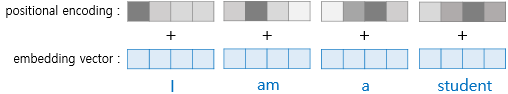
<br>
트랜스포머는 입력 정보를 생성하기 위해 아래의 두 함수를 사용한다.<br>
임베딩 벡터 내의 각 차원의 인덱스가<br>
1) 짝수인 경우에는 사인 함수의 값을 사용하고<br>
2) 홀수인 경우에는 코사인 값을 사용한다.<br>
사인, 코사인 함수에 들어가는 각도는 `get_angles` 함수로 계산한다.
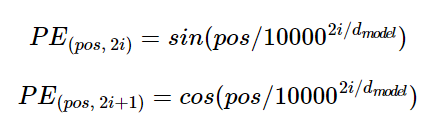

In [4]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 임베딩 벡터 내의 각 차원의 인덱스가 짝수인 경우에는 사인 함수의 값을 사용하고 
    sines = tf.math.sin(angle_rads[:, 0::2])
    
    # 홀수인 경우에는 코사인 함수의 값을 사용한다.
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape) # 나머지는 0으로 채운다
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
      return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


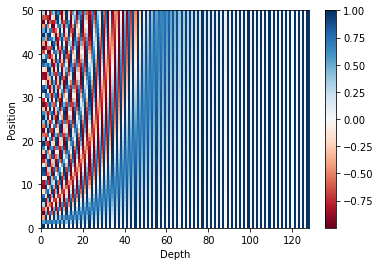

In [5]:
# 인코딩 결과를 시각화해보자
sample_pos_encoding = PositionalEncoding(50, 128) 
# (position, embedding vector size) - 단어의 총 개수, 임베딩 벡터 차원

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Depth = 임베딩 벡터 크기<br>
Position = 단어의 위치<br>

In [6]:
sample_pos_encoding.pos_encoding.numpy()[0][0].shape # position이 0번째인 단어의 벡터 크기

(128,)

In [7]:
sample_pos_encoding.pos_encoding.numpy()[0][0] # position이 0번째인 단어의 벡터 값

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1.], dtype=float32)

벡터의 인자 값의 인덱스가 짝수일 때 사인, 홀수일 때 코사인이다.<br>
해당 단어의 position이 0이기 때문에 sin(0) = 0, cos(0) = 1이므로 0과 1이 반복해서 나타나는 것을 알 수 있다.<br>
이렇게 계산된 positional encoding 값은 해당 단어의 embedding vectior 값과 합쳐진 후 transformer에 입력된다.

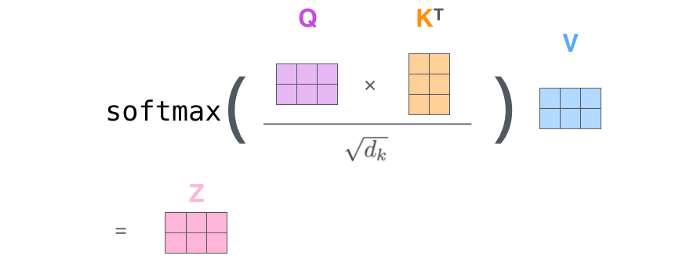

### __2. Scaled dot product attention__
Q, K, V 벡터를 얻었다면 각 Q벡터는 모든 K벡터에 대해서 어텐션 스코어를 구한 후 이를 softmax에 통과시키고 모든 V벡터를 가중합하여 최종적으로 어텐션 값을 구하게 된다.<br>
트랜스포머에서는 기존의 어텐션 함수(dot-product Attention) `q*k`에 임베딩 벡터 크기의 제곱근을 나눠준 형태의 함수를 사용하는데, 기존의 dot-product Attention을 스케일링했다는 의미로 __Scaled dot-product Attention__이라고 한다.<br>

이때, `q*k/(dk)^1/2`를 계산한 후 softmax 통과 전 마스킹 작업을 거쳐야 한다.<br> 
- __마스킹__이란, __어텐션에서 제외하기 위해 값을 가리는 작업__으로, 입력 문자열에는 문장의 시작이나 끝을 나타내는 토큰도 들어있기 때문에 해당 작업이 필요한 것이다.<br>
- 마스킹은 어텐션 스코어 행렬의 마스킹 위치에 __매우 작은 음수값__(본 코드에서는 -1e9(=10^-9)로 설정)을 넣어줌으로써 구현할 수 있다.
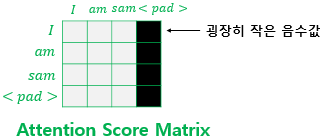

In [8]:
def scaled_dot_product_attention(query, key, value, mask):
  # 1. query * key
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 2-1. 임베딩 벡터 크기의 루트 값으로 나누기
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 2-2. 마스킹 : 문장의 시작 또는 끝을 나타내는 토큰일 경우 유사도 계산에서 제외
  if mask is not None:
    logits += (mask * -1e9)

  # 3. softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 4. value 곱하기
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

### __3. Multi-head Attention__
어텐션에서는 d_model 차원을 가지는 벡터를 헤드의 개수(num_heads)로 나눈 차원을 가지는 Q, K, V벡터로 바꾸고 어텐션을 수행한다. 즉, d_model 차원을 가진 벡터가 아니라 __차원을 축소시킨 벡터__로 어텐션을 수행한다. 이러한 작업을 거치는 이유는 한 번의 어텐션을 여러 번의 병렬작업으로 변환하기 위해서이다. (__어텐션을 병렬로 처리하는 게 더 효과적__이어서 그렇다고 한다.)<br>

- __어텐션을 병렬로 수행하는 이유는?__<br>
어텐션을 병렬로 수행하면 다양한 시각에서 정보들을 수집할 수 있다.<br>
예) 'John은 학교에 가지 않았다. 왜냐하면 그는 너무 피곤했기 때문이다.'<br>
  - Attention head 1 : 'John'과 '그'를 높게 연관지음<br>
  - Attention head 2 : 'John'과 '피곤하다'를 높게 연관지음
<br>

  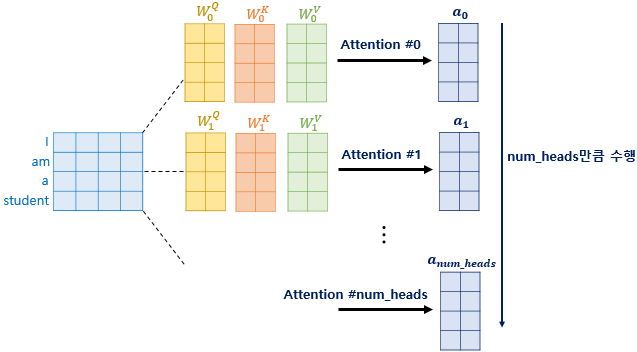

여러 개로 쪼갠 멀티헤드로 병렬 어텐션을 모두 수행하였다면, 모든 어텐션 헤드를 연결(concatenate)한다. 모두 연결된 어텐션 헤드 행렬의 크기는 `헤드 개수 * 헤드 차원 = d_model`이다.<br>

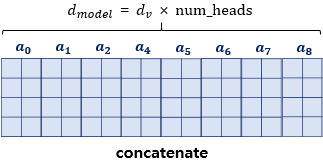

어텐션 헤드를 모두 연결한 행렬은 또 다른 가중치 행렬 `WO`을 곱하게 되는데, 이렇게 나온 결과 행렬이 멀티-헤드 어텐션의 최종 결과물이다.<br>

위에서 언급한 Multi-head Attention 작업 과정을 요약하자면 다음과 같다.<br>
1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 통과
2. 지정된 헤드 수(num_heads)만큼 나누기(split)
3. Scaled dot-product Attention
4. 나눠졌던 헤드들을 연결(concatenatetion)
5. `WO`에 해당하는 밀집층을 통과

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # split된 multi-head의 크기는 d_model / num_heads
    self.depth = d_model // self.num_heads

    # hidden layer : WQ, WK, WV에 해당하는 d_model 크기의 밀집층
    # 학습의 최종 목표는 이 세 개의 밀집층에 사용되는 최적의 가중치(W)를 구하는 것이다.
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # output layer : WO에 해당하는 d_model 크기의 밀집층
    self.out_dense = tf.keras.layers.Dense(units=d_model)

    # num_heads로 Q, K, V 행렬을 split하는 함수
    def split_heads(self, inputs, batch_size):
      inputs = tf.reshape(
          inputs, shape=(batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(inputs, perm=[0, 2, 1, 3]) # 행과 열을 교환한 행렬을 얻는다

    def forward(self, inputs):
      query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
      batch_size = tf.shape(query)[0]
    
      ## **** Multi-Head Attention 작업 수행 ****
      ## 1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 통과
      query = self.query_dense(query)
      key = self.key_dense(key)
      value = self.value_dense(value)

      ## 2. 지정된 헤드 수(num_heads)만큼 나누기(split)
      query = self.split_heads(query, batch_size)
      key = self.split_heads(key, batch_size)
      value = self.split_heads(value, batch_size)

      ## 3. Scaled dot-product Attention
      scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # 행과 열을 교환한 행렬을 얻는다

      ## 4. 나눠졌던 헤드들을 연결(concatenatetion)
      concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

      ## 5. WO에 해당하는 밀집층을 통과
      outputs = self.out_dense(concat_attention)

      return outputs